In [5]:
import sys
import pathlib

ROOT = pathlib.Path(".").absolute().parent.parent
sys.path.append(str(ROOT))

from utils.metrics import (
    plot_classification_report,
    print_scores,
    sklearn_make_predictions
)
import os
import pickle
from datasets.SPCUP22DataModule import SPCUP22DataModule
from features.audio import MFCC
from utils.config import load_config_file
from torchvision.transforms import Compose

### Load config

In [6]:
train_config = load_config_file(ROOT.joinpath("config", "train_params.yaml"))[
    "svm"
]

### Load model

In [7]:
checkpoint_path = ROOT.joinpath(
    "checkpoints", "svm", "with_unseen", "last.pkl"
)
result_save_path = ROOT.joinpath("results", "svm", "with_unseen")

In [8]:
classifier = None
with open(checkpoint_path, "rb") as checkpoint_file_object:
    classifier = pickle.load(checkpoint_file_object)

### Hyperparams

In [9]:
n_mfcc = train_config["features"]["n_mfcc"]
hop_length = train_config["features"]["hop_length"]

In [10]:
batch_size = 300
mfcc_extractor = MFCC(n_mfcc=n_mfcc, hop_length=hop_length)
transforms = Compose([mfcc_extractor])

### Data module

In [11]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    transform=transforms,
    should_include_unseen_in_training_data=True
)
data_module.prepare_data()
data_module.setup()

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...


In [12]:
actual_labels, predicted_labels, predicted_probabilities, filepaths = (
    sklearn_make_predictions(classifier, data_module, batch_size)
)

100%|██████████| 4/4 [00:35<00:00,  8.89s/it]


In [13]:
print_scores(actual_labels, predicted_labels)


    F1 Score: 0.86
    Accuracy: 0.86
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

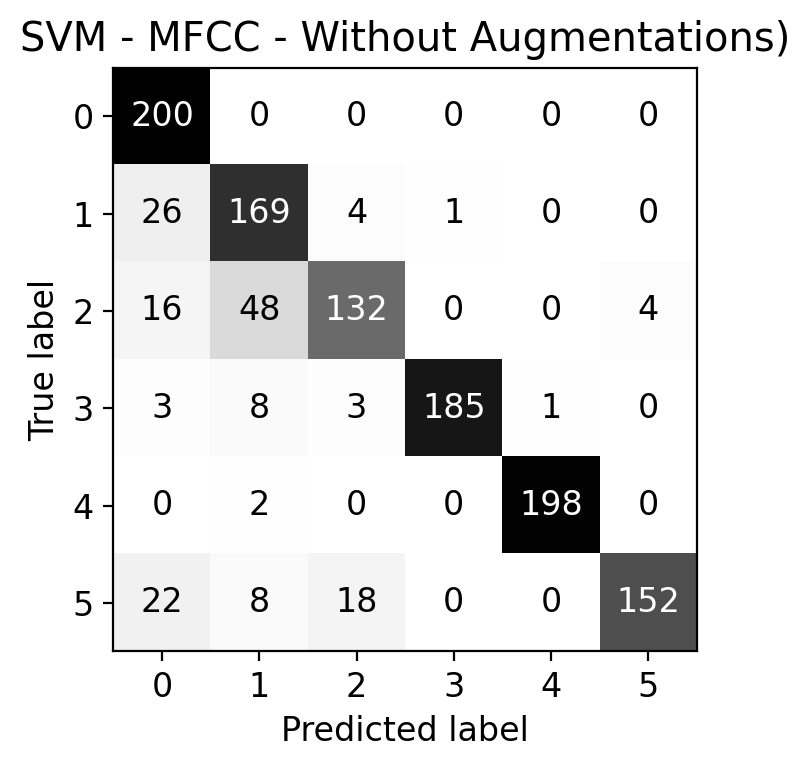

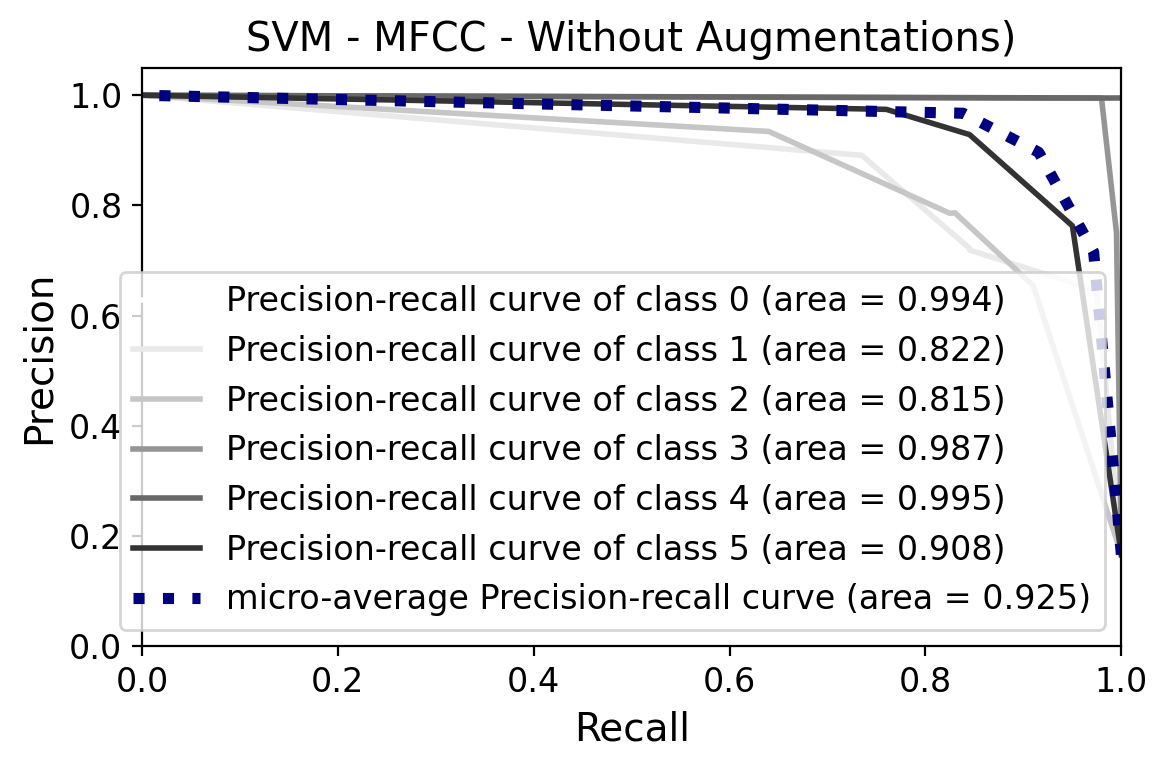

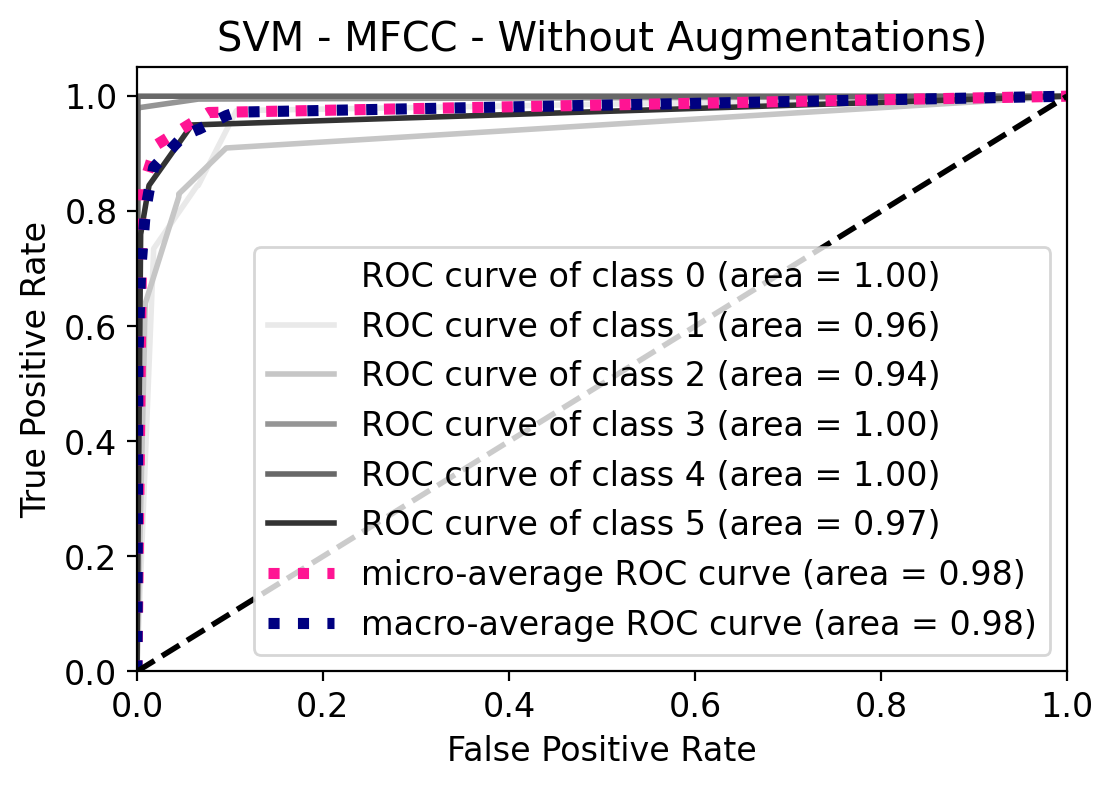

In [14]:
fig_save_path = str(ROOT.joinpath("results", "svm", "with_unseen"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    actual_labels,
    predicted_labels,
    predicted_probabilities,
    title_suffix="SVM - MFCC - Without Augmentations)",
    save_path=fig_save_path,
)

### With augmentations

In [15]:
checkpoint_path = ROOT.joinpath(
    "checkpoints", "svm", "with_unseen_aug", "last.pkl"
)
result_save_path = ROOT.joinpath("results", "svm", "with_unseen_aug")

In [16]:
classifier = None
with open(checkpoint_path, "rb") as checkpoint_file_object:
    classifier = pickle.load(checkpoint_file_object)

In [17]:
n_mfcc = train_config["features"]["n_mfcc"]
hop_length = train_config["features"]["hop_length"]

In [18]:
batch_size = 240
mfcc_extractor = MFCC(n_mfcc=n_mfcc, hop_length=hop_length)
transforms = Compose([mfcc_extractor])

In [19]:
data_module = SPCUP22DataModule(
    batch_size=batch_size,
    dataset_root=str(ROOT.joinpath("data", "raw_audio", "spcup22").absolute()),
    should_include_augmented_data=True,
    should_include_unseen_in_training_data=True,
    transform=transforms,
)
data_module.prepare_data()
data_module.setup()

Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_training_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_unseen.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part1_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/part2_aug.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part1.zip]...
Skipping downloading [/home/iubnlp/spcup22/SPCUP2022/data/raw_audio/spcup22/spcup_2022_eval_part2.zip]...


In [20]:
actual_labels, predicted_labels, predicted_probabilities, filepaths = (
    sklearn_make_predictions(classifier, data_module, batch_size)
)

100%|██████████| 20/20 [02:43<00:00,  8.18s/it]


In [21]:
print_scores(actual_labels, predicted_labels)


    F1 Score: 0.97
    Accuracy: 0.97
    


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

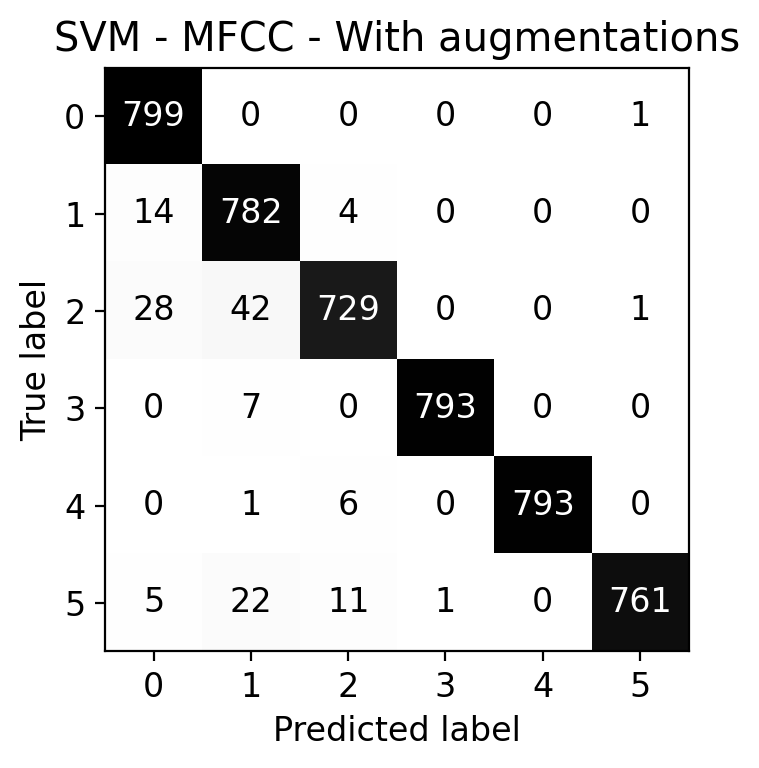

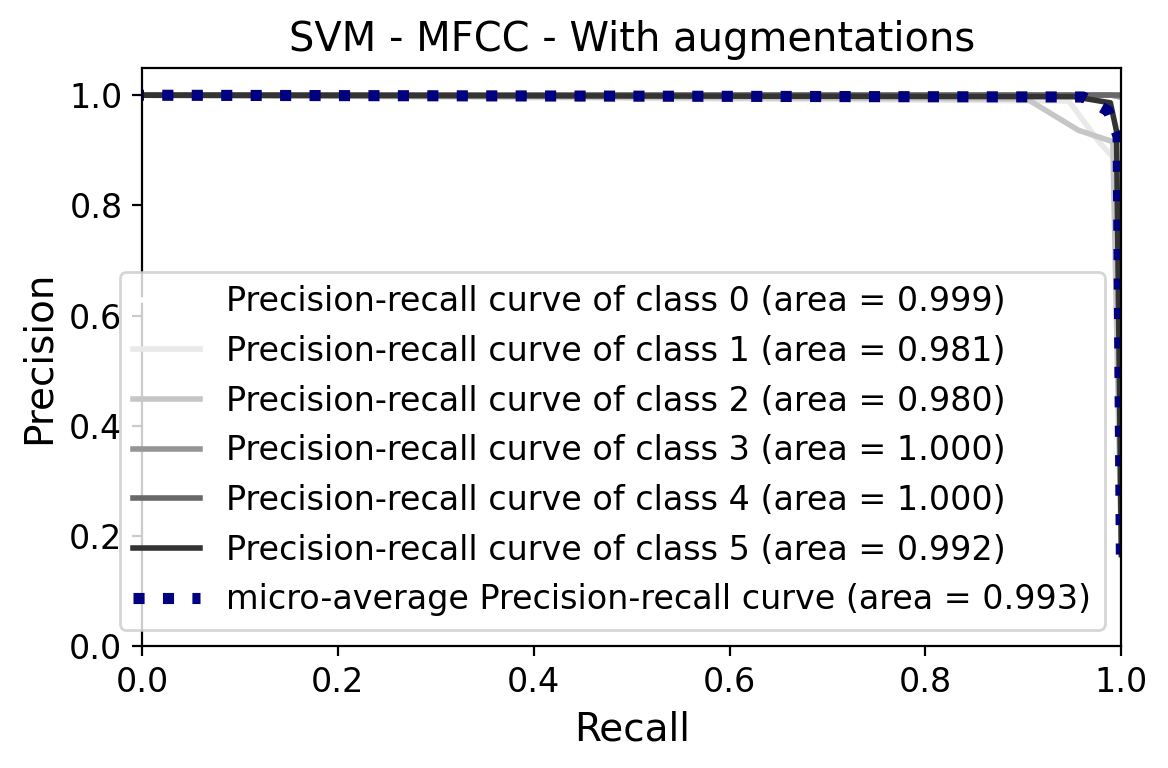

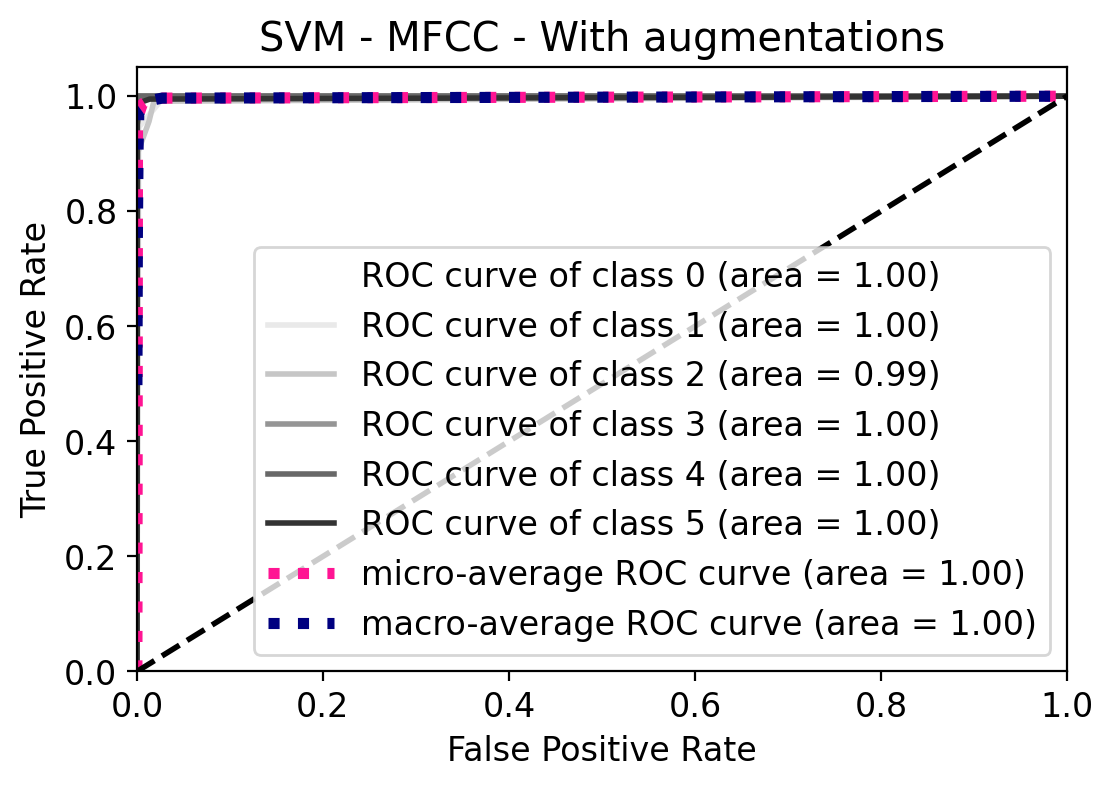

In [22]:
fig_save_path = str(ROOT.joinpath("results", "svm", "with_unseen_aug"))
os.makedirs(fig_save_path, exist_ok=True)

plot_classification_report(
    actual_labels,
    predicted_labels,
    predicted_probabilities,
    title_suffix="SVM - MFCC - With augmentations",
    save_path=fig_save_path,
)